In [1]:
%config IPCompleter.greedy=True
from IPython.display import IFrame

import pandas as pd
import numpy as np
import string
import math

import scipy.stats as sts

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn import preprocessing as prep
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
from sklearn import discriminant_analysis as disan
from sklearn import calibration as calib
from sklearn import linear_model as lm
from sklearn import svm
from sklearn import gaussian_process as gaup
from sklearn import mixture as mix
from sklearn import tree
from sklearn import ensemble as ens

import tensorflow as tf
from tensorflow import keras

# from keras import models as kermdls
# from keras import layers as kerlrs
# from keras import metrics as kmetrics

from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import Trials, STATUS_OK, tpe

import pickle

import nilearn as nl
from nilearn import plotting, image
from nilearn import datasets
import nibabel as nb
import h5py

import os

import time

Using TensorFlow backend.


In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5842895475687595805
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 211328624752301865
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6589725830
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12790251281507067589
physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13730999057757083345
physical_device_desc: "device: XLA_GPU device"
]


In [5]:
# fnc_10 = pd.read_csv('00_Data/fnc.csv')
# fnc_10 = fnc_10.head(5)
# for row in fnc_10.iterrows():
#     idx = int(row[1][0])
#     row = row[1][1:]
#     print(row)
#     row.to_csv('00_Data/fnc_csv_norm/{0}.csv'.format(idx))

In [6]:
TEST_IDS = [map_id.split('.')[0] for map_id in sorted(os.listdir('00_Data/fMRI_test'))]
TRAIN_IDS = [map_id.split('.')[0] for map_id in sorted(os.listdir('00_Data/fMRI_train'))]

In [52]:
data = pd.read_csv('00_Data/train_scores.csv')
data

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10005,66.532630,NaN,NaN,52.108977,69.993075
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421
...,...,...,...,...,...,...
5872,21746,14.257265,21.358872,61.165998,51.778483,54.640179
5873,21747,55.456978,68.169675,29.907995,55.349257,54.019517
5874,21750,48.948756,55.114811,60.878271,38.617246,50.679885
5875,21752,66.532630,59.844808,72.303110,55.458281,46.870235


In [53]:
data.isnull().sum()

Id                0
age               0
domain1_var1    438
domain1_var2    438
domain2_var1     39
domain2_var2     39
dtype: int64

In [54]:
data = data.dropna()

In [55]:
print('Dataset length: ', len(data.index))

Dataset length:  5434


In [11]:
def get_inputs(idx, labels):
    df_fnc = pd.read_csv('00_Data/fnc_csv/{0}.csv'.format(idx), index_col=0)
    X_fnc = np.array(df_fnc.values).reshape(-1)
    
    df_loading = pd.read_csv('00_Data/loading_csv/{0}.csv'.format(idx), index_col=0)
    X_loading = np.array(df_loading.values).reshape(-1)

    X = (X_fnc, X_loading)
    return X, labels

In [12]:
def map_decorator(func):
    def wrapper(idx, labels):
        # Use a tf.py_function to prevent auto-graph from compiling the method
        return tf.py_function(func,
                              inp=(idx, labels),
                              Tout=tf.float64)
    return wrapper

In [13]:
def new_py_function(func, inp, Tout, name=None):
    
    def wrapped_func(*flat_inp):
        reconstructed_inp = tf.nest.pack_sequence_as(inp, flat_inp,
                                                     expand_composites=True)
        out = func(*reconstructed_inp)
        return tf.nest.flatten(out, expand_composites=True)
    
    flat_Tout = tf.nest.flatten(Tout, expand_composites=True)
    flat_out = tf.py_function(func=wrapped_func, 
                              inp=tf.nest.flatten(inp, expand_composites=True),
                              Tout=[_tensor_spec_to_dtype(v) for v in flat_Tout],
                              name=name)
    spec_out = tf.nest.map_structure(_dtype_to_tensor_spec, Tout, expand_composites=True)
    out = tf.nest.pack_sequence_as(spec_out, flat_out, expand_composites=True)
    return out

def _dtype_to_tensor_spec(v):
    return tf.TensorSpec(None, v) if isinstance(v, tf.dtypes.DType) else v

def _tensor_spec_to_dtype(v):
    return v.dtype if isinstance(v, tf.TensorSpec) else v

In [14]:
def get_dataset(data, batch_size):
    data = tf.data.Dataset.from_tensor_slices((data['Id'].values, 
                                               data[['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']].values))
    data = data.shuffle(buffer_size=5500, seed=30, reshuffle_each_iteration=True)
    
    data = data.map(lambda idx, lbl:new_py_function(get_inputs, inp=(idx, lbl), Tout=((tf.float64, tf.float64), tf.float64), name=None), 
                     num_parallel_calls=tf.data.experimental.AUTOTUNE, 
                     deterministic=True)
    data = data.batch(batch_size, drop_remainder=True)
    data = data.prefetch(tf.data.experimental.AUTOTUNE)
    return data

In [15]:
train, test = model_selection.train_test_split(data, test_size=0.2, shuffle=True, random_state=30)
train, val = model_selection.train_test_split(train, test_size=0.2, shuffle=True, random_state=30)

In [16]:
batch_size = 64

ds_train = get_dataset(train, batch_size)
ds_val = get_dataset(val, batch_size)
ds_test = get_dataset(test, batch_size)

In [17]:
INPUT_SHAPE_fnc = (1378,)

In [18]:
INPUT_SHAPE_loading = (26,)

In [19]:
inputs_fnc = keras.layers.Input(shape=INPUT_SHAPE_fnc, name='inp_fnc')

x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(inputs_fnc)
x = keras.layers.Dense(2048,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(x)
x = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(x)

x1 = keras.layers.Dense(512,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(x)
x1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(x1)
x1 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(x1)

x2 = keras.layers.Dense(512,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(x)
x2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(x2)
x2 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(x2)

x = keras.layers.concatenate([x1, x2])

x = keras.layers.Dense(512,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(x)
x = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(x)

# output
x = keras.Model(inputs=inputs_fnc, outputs=x, name='model_fnc')

In [20]:
inputs_loading = keras.layers.Input(shape=INPUT_SHAPE_loading, name='inp_load')

y = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(inputs_loading)

y = keras.layers.Dense(256,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(y)
y = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y)

y1 = keras.layers.Dense(128,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(y)
y1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y1)
y1 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(y1)

y2 = keras.layers.Dense(128,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(y)
y2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y2)
y2 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(y2)

y = keras.layers.concatenate([y1, y2])

y = keras.layers.Dense(512,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(y)
y = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y)

# output
y = keras.Model(inputs=inputs_loading, outputs=y, name='model_loading')

In [21]:
concat = keras.layers.concatenate([x.output, y.output])
concat = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(concat)

z1 = keras.layers.Dense(1024, 
                       kernel_initializer=keras.initializers.he_normal(seed=30),
                       bias_initializer=keras.initializers.Constant(5.))(concat)
z1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(z1)
z1 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(z1)

z2 = keras.layers.Dense(1024, 
                       kernel_initializer=keras.initializers.he_normal(seed=30),
                       bias_initializer=keras.initializers.Constant(5.))(concat)
z2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(z2)
z2 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(z2)

z = keras.layers.concatenate([z1, z2])

z = keras.layers.Dense(2048, 
                       kernel_initializer=keras.initializers.he_normal(seed=30),
                       bias_initializer=keras.initializers.Constant(5.))(z)
z = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(z)

outputs = keras.layers.Dense(5, activation='linear')(z)

model = keras.Model(inputs=[x.input, y.input], outputs=outputs, name='model_combined')

In [22]:
model.summary()

Model: "model_combined"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_fnc (InputLayer)            [(None, 1378)]       0                                            
__________________________________________________________________________________________________
inp_load (InputLayer)           [(None, 26)]         0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1378)         5512        inp_fnc[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 26)           104         inp_load[0][0]                   
_____________________________________________________________________________________

In [23]:
# optim = keras.optimizers.Adam(lr=0.000001,
#                                  beta_1=0.99,
#                                  beta_2=0.999,
#                                  amsgrad=False)

optim = tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95)
        
METRICS = [keras.metrics.RootMeanSquaredError(name='rmse'),
           keras.metrics.MeanSquaredError(name='mse'),
           keras.metrics.MeanAbsoluteError(name='mae')]

In [24]:
# def weighted_mae(y_true, y_pred):
# #     tf.print(y_true)
#     W = tf.constant([[0.2, 0.2, 0.2, 0.2, 0.2]])
# #     tf.print(W / tf.math.reduce_mean(y_true, axis=0))
#     return tf.math.reduce_mean(tf.linalg.matmul(tf.math.abs(y_pred - y_true), tf.transpose(W / tf.math.reduce_mean(y_true, axis=0))), axis=0)

In [25]:
model.compile(loss='mae', metrics=METRICS, optimizer=optim)

In [26]:
checkpoint_prefix = os.path.join('./99_Training_checkpoints/fnc-loading', "ckpt_{epoch}")

callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./99_Logs/fnc-loading'),
             tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                save_weights_only=True),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=0.001, 
                                              patience=10, 
                                              verbose=1, 
                                              mode='min',
                                              baseline=None, 
                                              restore_best_weights=True)]

In [27]:
with tf.device('/GPU:0'):
    hist = model.fit(ds_train,
                     validation_data=ds_val,
                     callbacks=callbacks,
                     epochs=400,
                     verbose=1)

Epoch 1/400
54/54 [==============================] - 17s 313ms/step - loss: 47.0244 - rmse: 49.4344 - mse: 2443.7563 - mae: 47.0244 - val_loss: 44.1981 - val_rmse: 48.8258 - val_mse: 2383.9600 - val_mae: 44.1981
Epoch 2/400
54/54 [==============================] - 14s 263ms/step - loss: 46.1452 - rmse: 48.5971 - mse: 2361.6782 - mae: 46.1452 - val_loss: 43.7692 - val_rmse: 47.5665 - val_mse: 2262.5764 - val_mae: 43.7692
Epoch 3/400
54/54 [==============================] - 14s 262ms/step - loss: 45.2290 - rmse: 47.7258 - mse: 2277.7534 - mae: 45.2290 - val_loss: 43.4019 - val_rmse: 46.7591 - val_mse: 2186.4146 - val_mae: 43.4019
Epoch 4/400
54/54 [==============================] - 15s 274ms/step - loss: 44.2547 - rmse: 46.8024 - mse: 2190.4639 - mae: 44.2547 - val_loss: 42.9170 - val_rmse: 46.0043 - val_mse: 2116.3979 - val_mae: 42.9170
Epoch 5/400
54/54 [==============================] - 14s 267ms/step - loss: 43.2501 - rmse: 45.8442 - mse: 2101.6951 - mae: 43.2501 - val_loss: 42.0989 

In [28]:
with tf.device('/GPU:0'):
    results = model.evaluate(ds_test, verbose=1)

16/16 [==============================] - 3s 214ms/step - loss: 8.3880 - rmse: 10.7065 - mse: 114.6287 - mae: 8.3880


Text(0.5, 1.0, 'Metric')

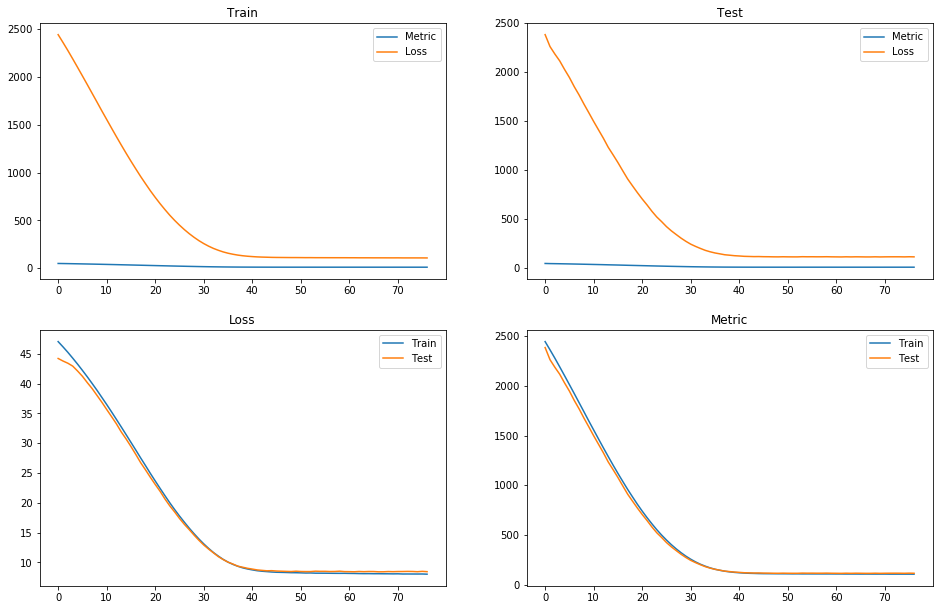

In [29]:
    fig = plt.figure()
    fig.set_size_inches(16,16)

    ax=fig.add_subplot(3,2,1)
    ax.plot(hist.history['rmse'])
    ax.plot(hist.history['mse'])
    ax.legend(['Metric', 'Loss'])
    ax.set_title('Train')

    ax=fig.add_subplot(3,2,2)
    ax.plot(hist.history['val_rmse'])
    ax.plot(hist.history['val_mse'])
    ax.legend(['Metric', 'Loss'])
    ax.set_title('Test')

    ax=fig.add_subplot(3,2,3)
    ax.plot(hist.history['loss'])
    ax.plot(hist.history['val_loss'])
    ax.legend(['Train', 'Test'])
    ax.set_title('Loss')

    ax=fig.add_subplot(3,2,4)
    ax.plot(hist.history['mse'])
    ax.plot(hist.history['val_mse'])
    ax.legend(['Train', 'Test'])
    ax.set_title('Metric')

In [30]:
X1_test = pd.read_csv('00_Data/fnc.csv')
X1_test = X1_test[X1_test['Id'].isin(TEST_IDS)]
X1_test = X1_test.to_numpy()
X1_test = X1_test[:,1:]

In [31]:
X2_test = pd.read_csv('00_Data/loading.csv')
X2_test = X2_test[X2_test['Id'].isin(TEST_IDS)]
X2_test = X2_test.to_numpy()
X2_test = X2_test[:,1:]

In [32]:
y_preds = model.predict([X1_test, X2_test])

In [33]:
y_preds = y_preds.flatten()

In [34]:
df_submission = []
i = 0
for idx in TEST_IDS:
    df_submission.append(['{0}_age'.format(idx), y_preds[i]])
    df_submission.append(['{0}_domain1_var1'.format(idx), y_preds[i+1]])
    df_submission.append(['{0}_domain1_var2'.format(idx), y_preds[i+2]])
    df_submission.append(['{0}_domain2_var1'.format(idx), y_preds[i+3]])
    df_submission.append(['{0}_domain2_var2'.format(idx), y_preds[i+4]])
    i += 5

df_submission = pd.DataFrame(df_submission, columns=['Id', 'Predicted'])

In [35]:
df_submission.to_csv('submission_fnc-load_mae_13_1.csv', index=False)

In [36]:
data = pd.read_csv('00_Data/train_scores.csv')
data

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10005,66.532630,NaN,NaN,52.108977,69.993075
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421
...,...,...,...,...,...,...
5872,21746,14.257265,21.358872,61.165998,51.778483,54.640179
5873,21747,55.456978,68.169675,29.907995,55.349257,54.019517
5874,21750,48.948756,55.114811,60.878271,38.617246,50.679885
5875,21752,66.532630,59.844808,72.303110,55.458281,46.870235


In [37]:
data_nulls = data[data.isnull().any(axis=1)]
NULL_IDS = list(data_nulls['Id'].values)

In [40]:
len(NULL_IDS)

443

In [66]:
NULL_IDS[0]

10005

In [67]:
X2_test0[0]

array([-0.00039777,  0.0068783 ,  0.0090508 ,  0.00036861,  0.00033614,
        0.010679  ,  0.010352  ,  0.0036373 ,  0.0041797 ,  0.021058  ,
        0.00037733,  0.0043287 ,  0.0052555 ,  0.013587  ,  0.040847  ,
        0.0087954 ,  0.0097025 ,  0.017257  ,  0.0054543 , -0.0085907 ,
        0.019416  ,  0.00078579,  0.0026917 , -0.019814  ,  0.017105  ,
        0.013316  ])

In [41]:
X1_test0 = pd.read_csv('00_Data/fnc.csv')
X1_test0 = X1_test0[X1_test0['Id'].isin(NULL_IDS)]
X1_test0 = X1_test0.to_numpy()
X1_test0 = X1_test0[:,1:]

In [42]:
X2_test0 = pd.read_csv('00_Data/loading.csv')
X2_test0 = X2_test0[X2_test0['Id'].isin(NULL_IDS)]
X2_test0 = X2_test0.to_numpy()
X2_test0 = X2_test0[:,1:]

In [43]:
y_preds0 = model.predict([X1_test0, X2_test0])

In [72]:
data0 = pd.DataFrame(y_preds0, columns=['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2'])
data0['Id'] = NULL_IDS
data0.head()

,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2,Id
0,58.328247,56.113045,61.312927,47.656857,51.269760,10005
1,57.524712,50.928867,58.601677,52.624821,47.192249,10031
2,33.996037,45.362484,59.292316,41.288094,51.983246,10041
3,51.467770,55.568146,58.913914,45.418987,53.879906,10064
4,31.419174,45.484673,59.191605,44.294933,54.759743,10076


In [73]:
data0 = pd.concat([data, data0], ignore_index=True)

In [74]:
data0

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10007,38.617381,49.197021,65.674285,40.151376,34.096421
4,10008,35.326582,15.769168,65.782269,44.643805,50.448485
...,...,...,...,...,...,...
5872,21654,53.103634,50.951656,62.168022,49.389400,53.020847
5873,21665,38.246437,48.018227,59.522285,45.697098,53.208160
5874,21674,69.414169,58.593918,60.298779,49.865669,47.863167
5875,21693,62.009209,54.272484,60.474388,52.325031,52.989803


In [75]:
data0.to_csv('00_Data/train_scores_full.csv', index=False)